# tensorflow.data.Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random

2022-03-07 14:10:51.331213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 14:10:51.331261: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Train test split dataset

In [66]:
data_size = 1000 #(number of images to train on)
image_size = (64,64)

In [67]:
from sklearn.model_selection import train_test_split

path_to_mask_file = f'/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/{image_size[0]}x{image_size[1]}/Mask/with-mask-default-mask-seed'
path_to_no_mask_file = f'/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/{image_size[0]}x{image_size[1]}/No_mask/seed'

# File_list : list of all files
file_list = [(f'{path_to_mask_file}{str(i).zfill(4)}.png', f'{path_to_no_mask_file}{str(i).zfill(4)}.png') for i in np.arange(data_size)]

train,test= train_test_split(file_list,test_size=0.2,random_state=1,shuffle=True)
train[:2]

[('/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/Mask/with-mask-default-mask-seed0382.png',
  '/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/No_mask/seed0382.png'),
 ('/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/Mask/with-mask-default-mask-seed0994.png',
  '/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/No_mask/seed0994.png')]

## Read image function (X and y)

In [68]:
def X_y_images(filename):
    """ return X (mask) and y (no mask) from a file name"""
    #mask_im = np.asarray(Image.open(filename[0])).tolist()
    #no_mask_im = np.asarray(Image.open(filename[1])).tolist()
    
    mask_image = tf.io.read_file(filename[0])
    mask_image = tf.image.decode_png(mask_image)
    mask_image = tf.image.convert_image_dtype(mask_image, tf.float32)
    
    no_mask_image = tf.io.read_file(filename[1])
    no_mask_image = tf.image.decode_png(no_mask_image)
    no_mask_image = tf.image.convert_image_dtype(no_mask_image, tf.float32)
    
    return mask_image, no_mask_image

## Image augmentation

TO BE DONE

## Create dataset

In [69]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [70]:
# Create dataset as a sliced dataset
def create_dataset(file_list, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    # Shuffle data (so that the ordering is different at each epoch)
    ds = ds.shuffle(buffer_size=len(file_list))
    # Map dataset to get images
    ds = ds.map(X_y_images, num_parallel_calls=AUTOTUNE)
    # Map for data augmentation
    #ds = ds.map(image_augmentation_function, num_parallel_calls=5)
    # Batching
    ds = ds.batch(batch_size)
    # Prefetch (use several resources at the same time)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [71]:
create_dataset(train)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None))>

# Create model

## Data

In [72]:
train_ds=create_dataset(train)
test_ds=create_dataset(test)

## Model

In [73]:
from icangetyoursmile.models import unet, create_data_augmentation_model, join_unet_augm_models

In [74]:
input_size = (image_size[0], image_size[1],3)
input_size

(64, 64, 3)

In [75]:
model = join_unet_augm_models(unet(starting_power=4, input_size=input_size),
                              create_data_augmentation_model(random_flip="horizontal", random_rotation=0.03))

In [76]:
# callback to save model training on 5 images
from icangetyoursmile.custom_callbacks import CustomCallback
image_log = dict()
save_predict = CustomCallback(test, image_log)

In [77]:
# Data preparation for visualisation of 5 images through training
X_visu = []
path = f'/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/{image_size[0]}x{image_size[1]}/'
for number in range(5):
        rand_img_nb = random.randint(0,9999)
        mask_path = f'{path}Mask/with-mask-default-mask-seed{str(rand_img_nb).zfill(4)}.png'
        mask_im = np.asarray(Image.open(mask_path)).tolist()
        X_visu.append(mask_im)

image_log = dict()

In [78]:
# early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience= 250, restore_best_weights=True)

In [ ]:
history = model.fit(train_ds,
                    epochs=200, 
                    batch_size = 16,
                    #steps_per_epoch=steps_per_epoch,
                    #validation_steps=validation_steps,
                    validation_data=test_ds,
                    callbacks=[CustomCallback(X_visu, image_log)])

Epoch 1/200
25/25 [==============================] - 13s 490ms/step - loss: 0.2689 - val_loss: 0.2276
Epoch 2/200
25/25 [==============================] - 12s 455ms/step - loss: 0.1755 - val_loss: 0.1325
Epoch 3/200
25/25 [==============================] - 12s 464ms/step - loss: 0.0916 - val_loss: 0.0521
Epoch 4/200
25/25 [==============================] - 11s 447ms/step - loss: 0.0415 - val_loss: 0.0300
Epoch 5/200
25/25 [==============================] - 12s 498ms/step - loss: 0.0309 - val_loss: 0.0216
Epoch 6/200
25/25 [==============================] - 11s 459ms/step - loss: 0.0265 - val_loss: 0.0183
Epoch 7/200
25/25 [==============================] - 12s 488ms/step - loss: 0.0249 - val_loss: 0.0167
Epoch 8/200
25/25 [==============================] - 12s 466ms/step - loss: 0.0229 - val_loss: 0.0160
Epoch 9/200
25/25 [==============================] - 12s 488ms/step - loss: 0.0222 - val_loss: 0.0147
Epoch 10/200
25/25 [==============================] - 12s 474ms/step - loss: 0.021

Epoch 42/200
25/25 [==============================] - 11s 441ms/step - loss: 0.0163 - val_loss: 0.0121
Epoch 43/200
25/25 [==============================] - 11s 450ms/step - loss: 0.0159 - val_loss: 0.0127
Epoch 44/200
25/25 [==============================] - 11s 441ms/step - loss: 0.0158 - val_loss: 0.0117
Epoch 45/200
25/25 [==============================] - 11s 441ms/step - loss: 0.0159 - val_loss: 0.0120
Epoch 46/200
25/25 [==============================] - 11s 441ms/step - loss: 0.0159 - val_loss: 0.0119
Epoch 47/200
25/25 [==============================] - 11s 447ms/step - loss: 0.0159 - val_loss: 0.0125
Epoch 48/200
25/25 [==============================] - 12s 464ms/step - loss: 0.0157 - val_loss: 0.0126
Epoch 49/200
25/25 [==============================] - 11s 453ms/step - loss: 0.0156 - val_loss: 0.0116
Epoch 50/200
25/25 [==============================] - 12s 468ms/step - loss: 0.0156 - val_loss: 0.0128
Epoch 51/200
25/25 [==============================] - 12s 487ms/step - lo

25/25 [==============================] - 11s 444ms/step - loss: 0.0138 - val_loss: 0.0111
Epoch 91/200
25/25 [==============================] - 11s 445ms/step - loss: 0.0137 - val_loss: 0.0111
Epoch 92/200
25/25 [==============================] - 12s 469ms/step - loss: 0.0137 - val_loss: 0.0116
Epoch 93/200
25/25 [==============================] - 12s 478ms/step - loss: 0.0137 - val_loss: 0.0120
Epoch 94/200
25/25 [==============================] - 11s 440ms/step - loss: 0.0135 - val_loss: 0.0118
Epoch 95/200
25/25 [==============================] - 12s 474ms/step - loss: 0.0134 - val_loss: 0.0121
Epoch 96/200
25/25 [==============================] - 12s 481ms/step - loss: 0.0131 - val_loss: 0.0103
Epoch 97/200
25/25 [==============================] - 12s 469ms/step - loss: 0.0134 - val_loss: 0.0108
Epoch 98/200
25/25 [==============================] - 12s 466ms/step - loss: 0.0132 - val_loss: 0.0107
Epoch 99/200
25/25 [==============================] - 12s 462ms/step - loss: 0.0133 - 

Epoch 153/200
25/25 [==============================] - 11s 459ms/step - loss: 0.0109 - val_loss: 0.0083
Epoch 154/200
25/25 [==============================] - 12s 468ms/step - loss: 0.0110 - val_loss: 0.0092
Epoch 155/200
25/25 [==============================] - 12s 475ms/step - loss: 0.0109 - val_loss: 0.0089
Epoch 156/200
25/25 [==============================] - 12s 482ms/step - loss: 0.0110 - val_loss: 0.0085
Epoch 157/200
25/25 [==============================] - 12s 462ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 158/200
25/25 [==============================] - 11s 456ms/step - loss: 0.0110 - val_loss: 0.0081
Epoch 159/200
25/25 [==============================] - 12s 462ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 160/200
25/25 [==============================] - 12s 478ms/step - loss: 0.0106 - val_loss: 0.0083
Epoch 161/200
25/25 [==============================] - 13s 512ms/step - loss: 0.0106 - val_loss: 0.0082
Epoch 162/200
25/25 [==============================] - 12s 475ms

In [63]:
y_pred = model.predict(X_visu).astype(np.uint8)

In [64]:
def plot_results(X_test, y_pred):
    plt.figure(figsize=(20,10))
    nb_graphs = len(X_test)
    for graph_nb in range(nb_graphs):
        plt.subplot(2,nb_graphs, graph_nb+1)
        plt.imshow(X_test[graph_nb])
        plt.subplot(2,nb_graphs, graph_nb +1 +nb_graphs)
        plt.imshow(y_pred[graph_nb])

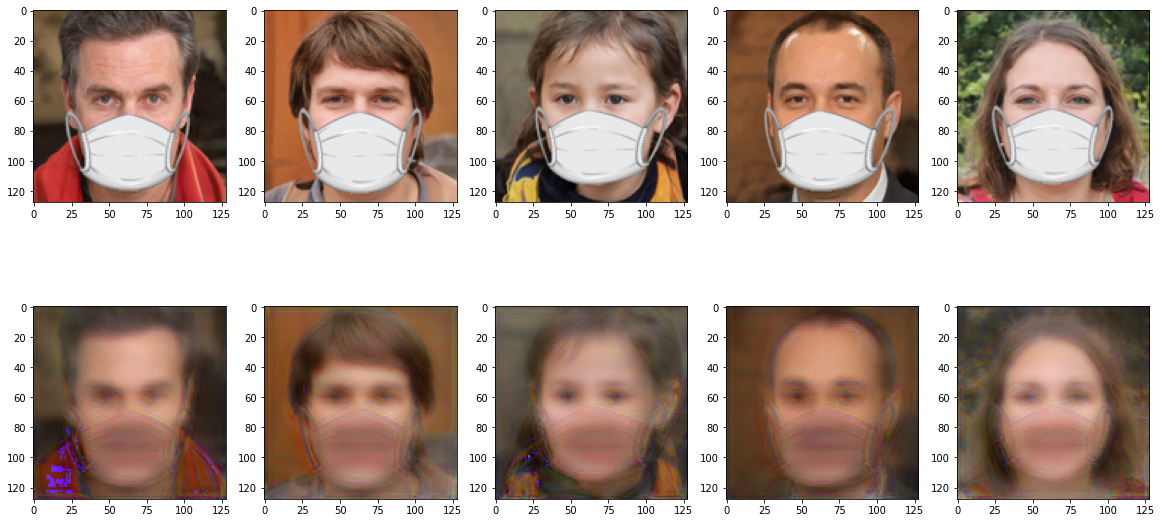

In [65]:
plot_results(X_visu, y_pred);